<a href="https://colab.research.google.com/github/sehwchoi/movie_recommendation/blob/main/Amazon_Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install surprise

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Surprise library for collaborative filtering algorithm
from surprise import *
from surprise.model_selection import GridSearchCV
from surprise.accuracy import rmse, mae, fcp
from surprise.model_selection import cross_validate

# Others
import pickle
import json
from os import listdir


In [ ]:
import sklearn
print(sklearn.__version__)

1.0.2


In [ ]:
# this project runs on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# train dataset is from http://jmcauley.ucsd.edu/data/amazon/
# tran dataset consists of Amazon Movies & TV reviews datasets
#train_df = pd.read_json('reviews.training.json', lines=True)
#train_df.to_csv('reviews.train.csv')

In [ ]:
# load cleaned training data table
file_path = '/content/drive/MyDrive/Colab Notebooks/reviews.train.csv'
#train_df = pd.read_csv(file_path, names=["reviewerID", "asin", "overall"])
train_df = pd.read_csv(file_path)

In [ ]:
print(train_df.dtypes)

Unnamed: 0         int64
asin              object
helpful           object
overall            int64
reviewText        object
reviewTime        object
reviewerID        object
reviewerName      object
summary           object
unixReviewTime     int64
dtype: object


# Data Exploratory 

In [ ]:
n_movies = train_df['asin'].nunique()
n_users = train_df['reviewerID'].nunique()
n_ratings = len(train_df)
print("Total unique movies: %d" % (n_movies))
print("Total users: %d" % (n_users))
print("Total ratings: %d" % (n_ratings))
density = n_ratings / float(n_users * n_movies)
print("Sparsity: %f" % (1-density))


Total unique movies: 50050
Total users: 123952
Total ratings: 1358026
Sparsity: 0.999781


In [ ]:
train_df.sample(n=100)

In [ ]:
train_df['overall'].describe()

count    1.358026e+06
mean     4.110995e+00
std      1.197396e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: overall, dtype: float64

In [ ]:
train_df.dtypes

reviewerID    object
asin          object
overall        int64
dtype: object

In [ ]:
# check if there is any null values in train dataset
train_df.isnull().sum()

Unnamed: 0           0
asin                 0
helpful              0
overall              0
reviewText          53
reviewTime           0
reviewerID           0
reviewerName      4900
summary             22
unixReviewTime       0
dtype: int64

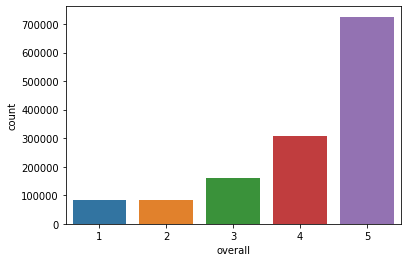

In [ ]:
# rating distributions
ax = sns.countplot(x="overall",data=train_df)

- Training dataset includes 1,358,026 ratings, and there are  50050 unique movies and 123952 unique users.
- Rating distribution shows users usually rated a movie 4 or 5 when they write a review.
- More than 75% of the rating data were 4 or 5 rates.

## Number of rated movies per user

In [ ]:
# number of rated movies per user distributions
# most of users rated one or two movies? might be skewed
ratings_per_user_count = pd.DataFrame(train_df.groupby('reviewerID')['overall'].mean())
ratings_per_user_count['ratings_per_user'] = pd.DataFrame(train_df.groupby('reviewerID')['overall'].count())
ratings_per_user_count.head()

,overall,ratings_per_user
reviewerID,,
A00295401U6S2UG3RAQSZ,4.00,5
A00348066Q1WEW5BMESN,5.00,5
A0040548BPHKXMHH3NTI,3.50,8
A00438023NNXSDBGXK56L,3.25,4
A0048168OBFNFN7WW8XC,5.00,7


In [ ]:
ratings_per_user_count.describe()

,overall,ratings_per_user
count,123952.000000,123952.000000
mean,4.202063,10.956064
std,0.729453,31.810722
min,1.000000,1.000000
25%,3.800000,4.000000
50%,4.333333,6.000000
75%,4.800000,9.000000
max,5.000000,1879.000000


In [ ]:
# 97 quantile to find the threhold for the outliers
ratings_per_user_count.quantile(.97)

overall              5.0
ratings_per_user    40.0
Name: 0.97, dtype: float64

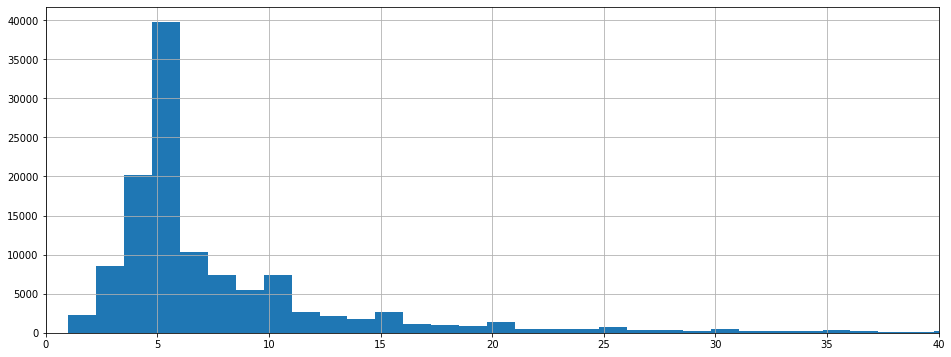

In [ ]:
# plot distribution over non outliers
plt.xlim(left=0, right = 40)
ratings_per_user_count['ratings_per_user'].hist(bins=1500, figsize=[16,6])

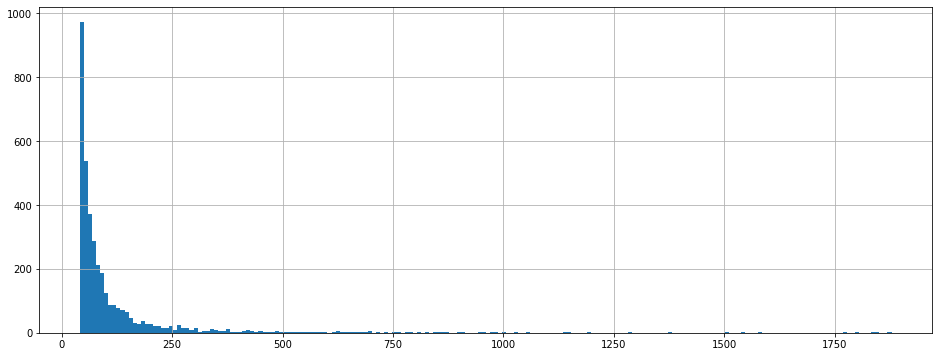

In [ ]:
# plot distribution over outliers 
ratings_per_user_count_outliers = ratings_per_user_count[ratings_per_user_count['ratings_per_user'] > 40]
ratings_per_user_count_outliers['ratings_per_user'].hist(bins=200, figsize=[16,6])

- Users in average rated 11 movies. Usually, users rated about 4~ 9 movies out of 50000 unique movies in the dataset. User who rated the most give ratings to 1879 movies.
- The above plot shows that the number of rated movies per user is right-skewed distribution. 97% of users gave ratings below 40 movies.
- Considering 50000 unique movies in the datset, this implies that they are a lot of missing data and a user-item matrix is very sparse.


## Number of ratings per movie

In [ ]:
# number of rated users per movie distributions
# popular movies will get lots of ratings? might be highly skewed
ratings_per_movie_count = pd.DataFrame(train_df.groupby('asin')['overall'].mean())
ratings_per_movie_count['ratings_per_movie'] = pd.DataFrame(train_df.groupby('asin')['overall'].count())
ratings_per_movie_count.head()

,overall,ratings_per_movie
asin,,
0005019281,4.512195,82
0005119367,4.767123,73
0307141985,5.000000,4
0307142469,4.741935,31
0307142477,2.600000,5


In [ ]:
ratings_per_movie_count.describe()

,overall,ratings_per_movie
count,50050.000000,50050.000000
mean,4.063479,27.133387
std,0.687280,58.769294
min,1.000000,1.000000
25%,3.700000,6.000000
50%,4.200000,10.000000
75%,4.577778,23.000000
max,5.000000,1785.000000


In [ ]:
ratings_per_movie_count.quantile(0.97)

overall                5.00
ratings_per_movie    151.53
Name: 0.97, dtype: float64

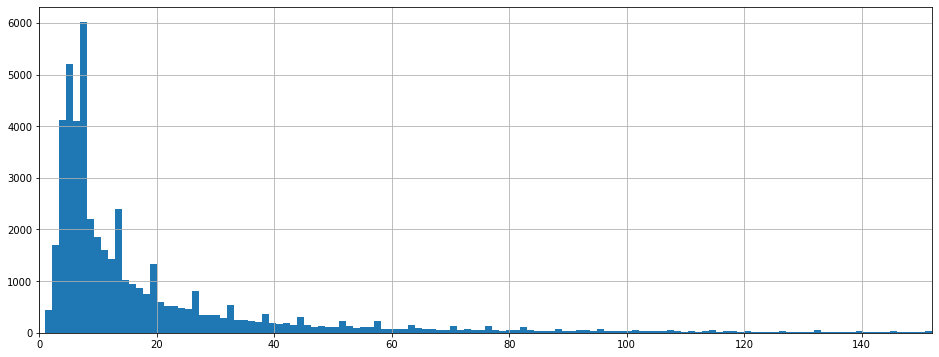

In [ ]:
# plot distribution over non-outliers
plt.xlim(left=0, right = 152)
ratings_per_movie_count['ratings_per_movie'].hist(bins=1500, figsize=[16,6])

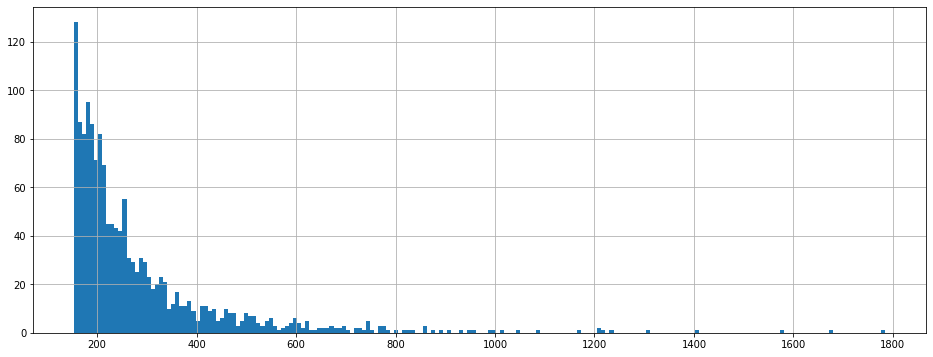

In [ ]:
# plot distribution over outliers 
ratings_per_movie_count_outliers = ratings_per_movie_count[ratings_per_movie_count['ratings_per_movie'] > 152]
ratings_per_movie_count_outliers['ratings_per_movie'].hist(bins=200, figsize=[16,6])

- Movie in average received 27 ratings. Most movies got ratings from 6 to 23. A movie which got most ratings received 1785 rates.
- Ratings per movie distribution is right-skewed as well. 97% of movies only got below 23 ratings. 
- This indicates that most of movies have missing ratings over users and  a user-item matrix would be a sparse matrix.


## Number of ratings over years

In [ ]:
train_df['reviewTime'] = pd.to_datetime(train_df['reviewTime'])

In [ ]:
ratings_per_year_count = pd.DataFrame(train_df.groupby(train_df["reviewTime"].dt.year)['overall'].mean())
ratings_per_year_count['ratings_per_year'] = pd.DataFrame(train_df.groupby(train_df["reviewTime"].dt.year)['overall'].count())
print(ratings_per_year_count)

             overall  ratings_per_year
reviewTime                            
1997        5.000000                 8
1998        4.118132               364
1999        4.004944              5259
2000        4.029570             27934
2001        4.008232             32069
2002        4.014124             39295
2003        4.000661             42365
2004        3.956143             58622
2005        3.955332             71102
2006        3.978294             68597
2007        4.061633             77978
2008        3.986360             73902
2009        3.985378             73245
2010        3.988727             74246
2011        3.995530             80764
2012        4.127610            124739
2013        4.282330            312050
2014        4.259209            195487


In [ ]:
ratings_per_year_count.describe()

# Data Preprocessing

In [ ]:
# Preprocessing. We are using reviewer Id, Movie Id, and Rates
def read_reviews(path):
    try:
        df = pd.read_csv(path)
        df = df[['reviewerID', 'asin', 'overall']]
        return df
    except Exception as error:
        print("Cannot read file: "+repr(error))
    

In [ ]:
# prepare train dataset
#train_df = read_reviews('reviews.train.csv')
#train_df.to_csv('reviews_train_cleaned.csv', index=False, header=False)
#train_df.head()

In [ ]:
# load train dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/reviews_train_cleaned.csv'
reader = Reader(line_format='user item rating', sep=',')
train_data = Dataset.load_from_file(file_path, reader=reader)

In [ ]:
# load test dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/reviews.dev.csv'
dev_df = pd.read_csv(file_path)
reader = Reader(line_format='user item rating', sep=',')
devdataset_data = Dataset.load_from_df(pd.DataFrame.from_records(dev_df.values), reader=reader).build_full_trainset().build_testset()
#test_data = Dataset.load_from_file(file_path, reader=reader).build_full_trainset().build_testset()

In [ ]:
dev_df.head()

,reviewerID,asin,overall
0,A34DNO6UAH67Z0,B000CDSS22,5
1,A3APW42N5MRVWT,6305186774,2
2,A20D9VGCF3P13L,B004LWZW24,5
3,A82LIVYSX6WZ9,B00001U0DM,3
4,A3LRKDF5WU4ZDO,B00005JOZI,3


In [ ]:
dev_df.describe()

,overall
count,169753.000000
mean,4.110932
std,1.198308
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
train_df.head()


,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B0090SI56Y,"[0, 0]",4,The movie was entertaining and falls in line w...,"12 22, 2013",AMFIPCYDYWGVT,AMRDxn,Entertaining,1387670400
1,1,B00005JL99,"[3, 6]",5,One thing to be said about Japanese horror/ext...,"11 19, 2003",A3G602Z4DWDZKS,Matthew King,Absolutely stunning! A battle not to be missed!,1069200000
2,2,B00109KN0M,"[27, 28]",5,Michelle Pfeiffer gives a brilliant performanc...,"02 13, 2008",A33BOYMVG3U58Y,TV Critic,Michelle Pfeiffer shines,1202860800
3,3,B00005JMPT,"[3, 4]",5,I wanted to see &quot;The Missing&quot; when i...,"06 18, 2004",ANEDXRFDZDL18,Serene Night,Hard Gritty Western,1087516800
4,4,B00005AAA9,"[0, 0]",4,I think &#34;Miss Congeniality&#34; is a light...,"10 22, 2013",A1VN7IS16PY024,Amazon Customer,Very entertaining but.....,1382400000


In [ ]:
# reviewerId existing in dev but not in train -> coldstart problem
#dev_df['reviewerID'].isin(train_df['reviewerID']).value_counts()
dev_df.loc[~dev_df['reviewerID'].isin(train_df['reviewerID'])]

,reviewerID,asin,overall
1273,A1D3L5ICB2KE0F,B0000C89IU,5
1542,AJSM8QWA4B8IP,B009LDD54K,5
4568,A3G6PW095IFNN5,0784011176,5
18804,A2VGI69KIN0AAH,B0013GS3WW,4
23685,A3UV0B32X7H4GC,0792833171,5
46348,A3E9C95QHGYKWH,630573240X,5
46456,A2VGI69KIN0AAH,0792842081,4
59372,AZTYHKV3MI0YL,0790734850,4
65472,A2VGI69KIN0AAH,B005LAIHUO,4
67223,AJSM8QWA4B8IP,630248443X,4


In [ ]:
# movie item existing in dev but not in train -> coldstart problem
dev_df.loc[~dev_df['asin'].isin(train_df['asin'])]

,reviewerID,asin,overall
21097,A2983OP6MDZ1M1,B004A30AW6,5
74445,A3EXHZD6MXE9L6,B004A30AW6,4


In [ ]:
# For Kaggle project submit
# prepare test dataset
# test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews.test.unlabeled.csv')
# test_df['overall'] = None
# test_df.head()

# Base Functions for Models

In [ ]:
def grid_search_algo(data, algorithm, param_grid):
  """ Return grid serach results with best paramter info

  Performs GridSearchCV with 3 cross validation using RMSE measures
  """

  gs = GridSearchCV(algorithm, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
  gs.fit(data)

  # best RMSE score
  print(gs.best_score['rmse'])

  # combination of parameters that gave the best RMSE score
  print(gs.best_params['rmse'])

  return gs

In [ ]:
def plot_grid_search(cv_results, grid_param_1, name_param_1, grid_param_2, name_param_2):
  scores_mean = cv_results['mean_test_rmse']
  scores_mean = np.array(scores_mean).reshape(len(grid_param_1), len(grid_param_2))

  for ind, i in enumerate(grid_param_1):
    plt.plot(grid_param_2, scores_mean[ind], label=name_param_1 + ": " + str(i)) 
  plt.legend()
  plt.xlabel(name_param_2)
  plt.ylabel('Mean score')
  plt.show()

In [ ]:
def rate_diff_distribution(predictions, model_name):
  dev_errors = []
  for prediction in predictions:
    dev_errors.append(abs(prediction.r_ui - prediction.est))

  dev_errors_df = pd.DataFrame({"diff" : dev_errors})
  dev_errors_df.head()
  #  distributions over error cases
  plt.subplots(1,1,figsize=(7,7))
  dev_errors_df['diff'].hist()
  plt.title(model_name)
  baseline_df_error = dev_errors_df[dev_errors_df['diff'] > 1.5]
  print("# of prediction error greater than 1.5: " , baseline_df_error.shape[0])

# Baseline - Predict ratings from the movie's average rating


In [ ]:
# get mean overall from ratings per movie table
ratings_per_movie_count.head()

NameError: ignored

In [ ]:
# left join with ratings_per_movie_count table created in EDA
dev_baseline_df = dev_df.merge(ratings_per_movie_count, on='asin', how='left')
dev_baseline_df.head()

In [ ]:
# compute RMSE on the dev
baseline_rmse = ((dev_baseline_df.overall_x - dev_baseline_df.overall_y) ** 2).mean() ** .5
print("Baseline RMSE : %f" % (baseline_rmse))

In [ ]:
# find cases where predicted rating difference from the actual is greater than 1.5
baseline_df_error = dev_baseline_df[abs(dev_baseline_df['overall_x']-dev_baseline_df['overall_y']) > 1.5]
baseline_df_error.head()

In [ ]:
print("Total cases where predicted rating is off by more than 1.5 %d" %(baseline_df_error.shape[0]))

# Model 1 - Memory Based Collaborative Filtering -  CoClustering

In [ ]:
# best param is {'n_cltr_u': 5, 'n_cltr_i': 5, 'n_epochs': 40}
param_grid = {
    'n_cltr_u' : [5, 10],
    'n_cltr_i' : [5, 10],
    'n_epochs': [40] }
gs = grid_search_algo(train_data, CoClustering, param_grid)
print(gs.cv_results)

1.1002973233640567
{'n_cltr_u': 5, 'n_cltr_i': 5, 'n_epochs': 40}
{'split0_test_rmse': array([1.10504911, 1.1048023 , 1.10222781, 1.10966502]), 'split1_test_rmse': array([1.09853408, 1.1028523 , 1.10204383, 1.11095124]), 'split2_test_rmse': array([1.09730878, 1.10221211, 1.10194987, 1.10644278]), 'mean_test_rmse': array([1.10029732, 1.1032889 , 1.10207384, 1.10901968]), 'std_test_rmse': array([0.00339705, 0.00110158, 0.00011543, 0.0018963 ]), 'rank_test_rmse': array([1, 3, 2, 4]), 'mean_fit_time': array([103.75910878, 136.43504357, 132.60298808, 119.83764021]), 'std_fit_time': array([11.26001278,  4.33011835,  3.83639382, 28.0740688 ]), 'mean_test_time': array([5.81220468, 5.90325785, 6.32240407, 5.16388583]), 'std_test_time': array([0.88349361, 1.1217454 , 1.16293239, 1.81669696]), 'params': [{'n_cltr_u': 5, 'n_cltr_i': 5, 'n_epochs': 40}, {'n_cltr_u': 5, 'n_cltr_i': 10, 'n_epochs': 40}, {'n_cltr_u': 10, 'n_cltr_i': 5, 'n_epochs': 40}, {'n_cltr_u': 10, 'n_cltr_i': 10, 'n_epochs': 40}]

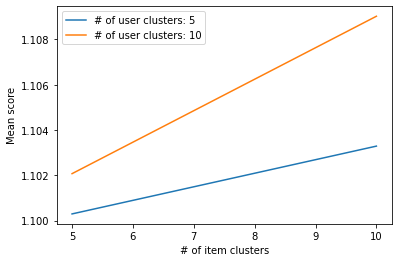

In [ ]:
plot_grid_search(gs.cv_results, param_grid['n_cltr_u'], '# of user clusters', param_grid['n_cltr_i'], '# of item clusters')

In [ ]:
model_cc = CoClustering(n_cltr_u = 5, n_cltr_i = 5, n_epochs = 40)
model_cc.fit(train_data.build_full_trainset())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


## CoClustering - Evaluate on the validation data

In [ ]:
predictions_cc = model_cc.test(devdataset_data)

# Then compute RMSE
dev_rmse_cc = rmse(predictions_cc)

RMSE: 1.0705


# of prediction error greater than 1.5:  25805


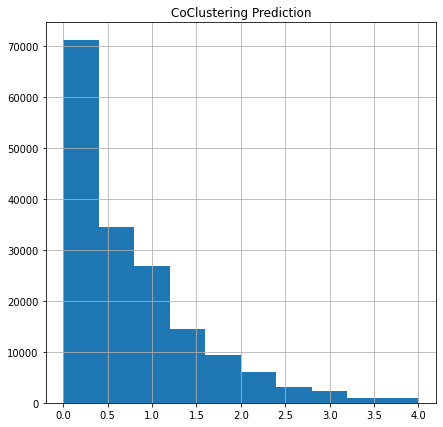

In [ ]:
rate_diff_distribution(predictions_cc, 'CoClustering Prediction')

# Model x - KNN 

In [ ]:
def evaluate_knn(data): 
    '''Item-based similarity chosen for this model.
       In addition, similarity between two items will be set to zero if number of common users
       per item is less than 5.
    '''
    sim_options = {'name': 'cosine',
                   'min_support': 5,
                   'user_based': False}
    rmse_algorithm = []

    for k in range(1, 20, 5):
      # split the dataset into five folds for cross-validation
      model = KNNWithMeans(k=k, min_k=1, sim_options=sim_options)
      print(model)
      knn_cv = cross_validate(model, data, measures=['RMSE'], cv=2, n_jobs=2, verbose=False)
      print(knn_cv['test_rmse'])
      #rmse_algorithm.append(knn_cv['test_rmse'].mean())
    return rmse_algorithm

In [ ]:
print(evaluate_knn(train_data))

Best fit param: {'n_cltr_u': 3, 'n_cltr_i': 3, 'n_epochs': 40}

# Model 2 - Model Based Collaborative Filtering - SVD

In [ ]:

def evaluate_algo(data, algorithm):
  """ Return rmse results for different n latent factors

  Evaluate algorithm with RMSE to find n_factors param
  """
  rmse_algorithm = []
  #  possible values of n_factors
  for k in range(1, 51, 5):
      algo = algorithm(n_factors = k)
      # 3 folds
      algo_perf = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=True)
      rmse_algorithm.append(algo_perf['test_rmse'].mean())
  return rmse_algorithm 

In [ ]:
#print(evaluate_algo(train_data, SVD))

In [ ]:
param_grid = {
    # utilize evaluate_algo to find possible values for n_factors param
    'n_factors': [10, 15, 20, 25, 30],
    'n_epochs': [40],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]}
gs = grid_search_algo(train_data, SVD, param_grid)
print(gs.cv_results)

1.015323311763278
{'n_factors': 10, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.1}
{'split0_test_rmse': array([1.03108089, 1.01487809, 1.07768499, 1.02773555, 1.03433373,
       1.01558666, 1.0805597 , 1.02826068, 1.03854552, 1.01582938,
       1.0787012 , 1.02814743, 1.03972221, 1.01599628, 1.0770329 ,
       1.02728829, 1.04038274, 1.01631313, 1.07381974, 1.0265786 ]), 'split1_test_rmse': array([1.03334101, 1.01630162, 1.0777495 , 1.0284351 , 1.03611678,
       1.01654901, 1.07973631, 1.02764321, 1.03909189, 1.0170213 ,
       1.08186256, 1.02805603, 1.04033264, 1.01709587, 1.07781366,
       1.02801937, 1.04292466, 1.01772449, 1.07569636, 1.02695578]), 'split2_test_rmse': array([1.03147168, 1.01479023, 1.07728535, 1.02706158, 1.03531412,
       1.01536045, 1.07965429, 1.02751592, 1.03696394, 1.01548538,
       1.07888964, 1.0274243 , 1.03956366, 1.01617683, 1.0766303 ,
       1.02723527, 1.04048778, 1.01623333, 1.07528272, 1.0270839 ]), 'mean_test_rmse': array([1.03196453, 1.01532

GridSearch with 3 folds shows that the best fit parameters for SVD is as below.

* {'n_factors': 10, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.1}

* RMSE on test folds : 1.015649335610912

In [ ]:
#algo = gs.best_estimator['rmse']
model_svd = SVD(n_factors=10, n_epochs=40, lr_all=0.005, reg_all=0.1)
model_svd.fit(train_data.build_full_trainset())

KeyboardInterrupt: ignored

## SVD - Evaluate on the validation data

In [ ]:
print("dev shape: %s" % (dev_df.shape,))
# evaluate on the validation data (Dev Data)
predictions_svd = model_svd.test(devdataset_data)

# Then compute RMSE
dev_rmse_svd = rmse(predictions_svd)

dev shape: (169753, 3)
RMSE: 1.0005


In [ ]:
rate_diff_distribution(predictions_svd)

# Discussion and Results

In [ ]:
df = pd.DataFrame({'model':['Baseline', 'CoClustering', 'SVD'], 'RMSE':[baseline_rmse, dev_rmse_cc, dev_rmse_svd]})
ax = df.plot.bar(x='model', y='RMSE', rot=0)

- This project recommend movies to user by predicting ratings for a given user and movie set. Coclustering and a well known collaborative filtering algorithm, Funk SVD models are built, and the results are compared to the baseline which is just average over all ratings for each movie. Parameters for each model are selected using the grid search and those that have the least RMSE over the cross validations.

- About dataset
  - Train data size: 1,358,026, about 50000 unique movies, 123952 unique movies
  - Test data size 169,753

- Coclustering prameters: TBD
- SVD Parameters: 10 factors and 3 cross validations

- Results
  - Coclustering RMSE: 1.071 SVD RMSE: 1.000, Baseline RMSE: 1.104
  - SVD performed slightly better than the basleine and the coclustering model. RMSE indicates that in average both models had about 1 rating off from the actual with having the scale from 1 to 5
- Error Analysis
  - Cases where the difference between actual and predicted values are greater than 1.5 -> Coclustering: 25842 SVD: 20567 cases baseline: 24781 cases


# Challenges and Future Works
- EDA shows that in most cases movies only get ratings from a few users. This aligns with the real world that users only see selected number of movies out of total movies. This can be problem in using SVD since a user-movie matrix is highly sparse and there would be many missing items to find latent factors. In a real case, it would make more sense to build a hybrid model which would use SVD on dense users and popular movies and predict ratings of unpopular movies based on their historical averages or their contents/meta information.
- It would be interesting to take account timestamp information in a model

# Kaggle submission Test data

In [ ]:
for i, row in test_df.iterrows():
    row['overall'] = round(algo.predict(row['reviewerID'], row['asin']).est)
test_df.head()
header = ['datapointID', 'overall']
test_df.to_csv('reviews.test.labeled_v3.csv', columns=header, index=False)

In [ ]:
dev_df = pd.read_csv('reviews.dev.csv')
preds = []
for i, row in dev_df.iterrows():
    preds.append(algo.predict(row['reviewerID'], row['asin']).est)

dev_df['preds'] = pd.Series(preds, index=dev_df.index)
dev_df.head()